# Notebook to generate some features by applying clustering techniques.

Table of contents <a id='top'>

1. [EDA](#eda)
2. [Validation Indexes](#indexes)
3. [Clustering Algorithms](#clustering)

    3.1. [K - Means](#kmeans)
    
    3.2. [Hierarchical (Ward)](#ward)
    
    3.3. [GMM](#gmm)
    
    3.4. [DBSCAN](#dbscan)
4. [Results Analysis](#results)

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_INTERIM, 'static_data.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
from sklearn.cluster import KMeans

In [2]:
# Get the data
X_train, X_test, y_train, y_test, encoder = sd.get_success_data(drop_time=False,
                                                                anon=False)

## 1. EDA <a id='eda'/>
[Top](#top)

In [3]:
X_train.head()

,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,duration,offer_type,reward_t,channel_email,channel_social,channel_mobile,channel_web,expected_finish
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,3.0,informational,0.0,1.0,1.0,1.0,0.0,240.0
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,4.0,informational,0.0,1.0,0.0,1.0,1.0,432.0
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,528.0
5,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,NaN,2018-04-25,None,NaN,1,17646,5.0,5.0,bogo,5.0,1.0,1.0,1.0,1.0,288.0
7,0011e0d4e6b944f998e987f904e8c1e5,0,3f207df678b143eea3cee63160fa8bed,40.0,2018-01-09,O,57000.0,0,17540,0.0,4.0,informational,0.0,1.0,0.0,1.0,1.0,96.0


In [4]:
customer_feats = ['age', 'gender', 'income', 'missing_demographics', 
                  'member_epoch_days']
offer_feats = ['difficulty', 'duration', 'offer_type', 'reward_t', 
               'channel_web', 'channel_social', 'channel_mobile', 
               'channel_email']

The interesting clustering is in the customers, as the offers are very few.

In [5]:
X_train_tr = encoder.fit_transform(X_train)
cust_train = X_train_tr[customer_feats]
print(cust_train.shape)
cust_train.head()

(50808, 5)


,age,gender,income,missing_demographics,member_epoch_days
0,33.0,1.0,72000.0,0,17277
1,33.0,1.0,72000.0,0,17277
2,33.0,1.0,72000.0,0,17277
5,NaN,NaN,NaN,1,17646
7,40.0,2.0,57000.0,0,17540


In [6]:
cust_train.isnull().mean()

age                     0.128326
gender                  0.128326
income                  0.128326
missing_demographics    0.000000
member_epoch_days       0.000000
dtype: float64

Let's drop the missing data for clustering (it's only 13% of the dataset, and imputing the missing data could generate new, artificial clusters, or distort the current ones). Also let's drop the duplicates.

In [7]:
unique_train = cust_train.dropna().drop_duplicates().drop(
    'missing_demographics', axis=1)
print(unique_train.shape)
unique_train.head()

(14748, 4)


,age,gender,income,member_epoch_days
0,33.0,1.0,72000.0,17277
7,40.0,2.0,57000.0,17540
12,59.0,0.0,90000.0,16864
17,24.0,0.0,60000.0,17116
21,26.0,0.0,73000.0,17338


### Let's scale the features

In [8]:
from sklearn.preprocessing import StandardScaler

In [9]:
scaler = StandardScaler()
scaler.fit(unique_train)

/home/miguel/anaconda3/envs/sbucks/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [10]:
X_s_train = pd.DataFrame(scaler.transform(unique_train),
                         index=unique_train.index,
                         columns=unique_train.columns)
X_s_train.head()

/home/miguel/anaconda3/envs/sbucks/lib/python3.7/site-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


,age,gender,income,member_epoch_days
0,-1.230638,0.769453,0.305519,0.146978
7,-0.827994,2.699367,-0.388848,0.774266
12,0.264895,-1.160461,1.138758,-0.838078
17,-1.748323,-1.160461,-0.249974,-0.237027
21,-1.633281,-1.160461,0.351810,0.292471


### Let's get some general visualization of the dataset

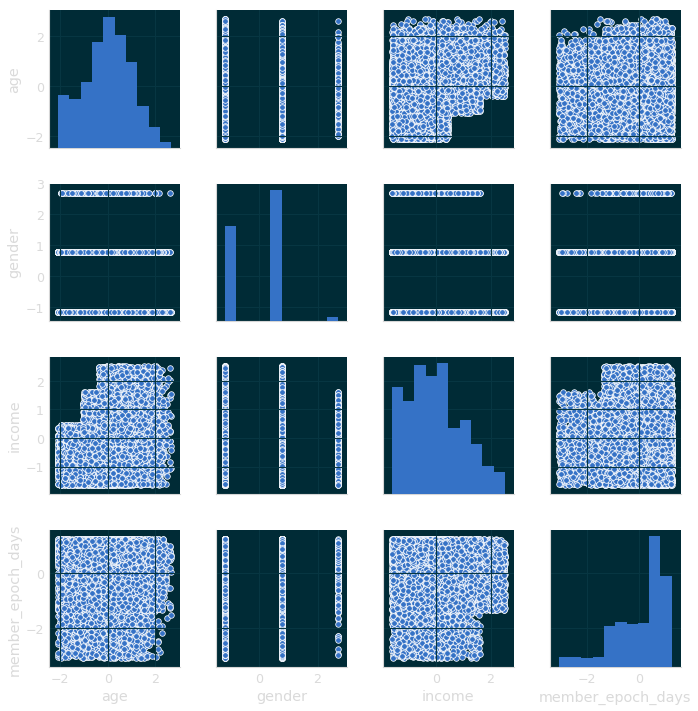

In [11]:
sns.pairplot(X_s_train)

There are some "artificial" stair-like shapes in the income-age plot, and also in the income-member_epoch_days plot. The thresholds could define clusters...

### Let's use PCA to visualize the dataset in 2D

In [12]:
from sklearn.decomposition import PCA

In [13]:
def pca_visualize(X, **kwargs):
    """ Applies PCA to get 2-D data and make a scatter plot."""
    extractor = PCA(n_components=2)
    X_pca = extractor.fit_transform(X)
    
    print('Explained variance ratio for the first two components: {}'.format(
        extractor.explained_variance_ratio_.sum()))
    
    plt.scatter(X_pca[:,0], X_pca[:,1], **kwargs)
    plt.title('PCA scatter plot')
    plt.xlabel('PCA 1')
    _ = plt.ylabel('PCA 2')

Explained variance ratio for the first two components: 0.614898618653607


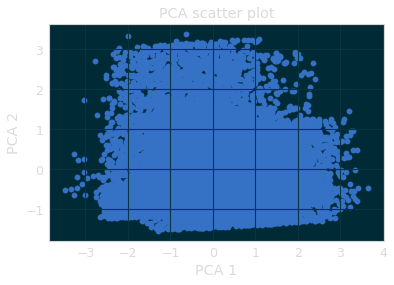

In [14]:
pca_visualize(X_s_train)

The 2-D representation looks good for GMM or DBSCAN. In next sections some clustering algorithms will be tested.

## 2. Validation Indexes <a id='indexes'/>
[Top](#top)

For comparing the models and validation, I will use the Silhouette score, and DBCV (Density Based Clustering Validation). As the main objective of this notebook is to get some new features, I will keep the clustering indexes of the methods that yield the best score in each of the metrics. I could also keep the best sample of each algorithm.

DBCV was implemented here: https://github.com/christopherjenness/DBCV

Let's try that library.

In [15]:
# import DBCV
from scipy.spatial.distance import euclidean

In [16]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_s_train)
cluster_labels = kmeans.predict(X_s_train)

In [17]:
# %time DBCV.DBCV(X_s_train.values, cluster_labels, euclidean)

Running that function for validation takes too long. I will only use the Silhouette score, and BIC in the case of GMM. Also the elbow method, and some visualizations with PCA

## 3. Clustering algorithms <a id='clustering'/>
[Top](#top)

### 3.1. K - Means <a id='kmeans'/>
[Top](#top)

In [18]:
kmeans = KMeans(n_clusters=4)
%time kmeans.fit(X_s_train)

CPU times: user 991 ms, sys: 12.1 ms, total: 1 s
Wall time: 687 ms


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [19]:
cluster = kmeans.predict(X_s_train)

In [20]:
def pca_visualize_clusters(X, cluster):
    """ Visualize all the clusters using PCA. """
    for c in np.unique(cluster):
        pca_visualize(X[cluster == c], label='cluster {}'.format(c))
    plt.legend()

Explained variance ratio for the first two components: 0.7528671109119514
Explained variance ratio for the first two components: 0.7389735924899288
Explained variance ratio for the first two components: 0.7045386598002185
Explained variance ratio for the first two components: 0.5955708783743272


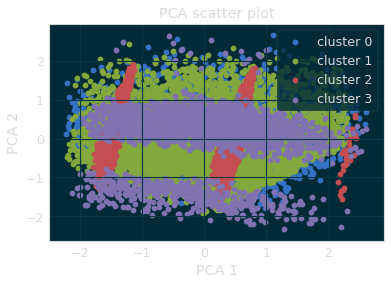

In [21]:
pca_visualize_clusters(X_s_train, cluster)

The visualization is not too informative. Let's use the Silhouette score to determine the best number of clusters.

In [22]:
from sklearn.metrics import silhouette_score
from time import time

In [23]:
def kmeans_error(X, method, cluster_labels):
    """ Index function for K-Means that returns the SSE"""
    return method.inertia_

In [24]:
def validate_clustering(X, clustering_algo, params, index_fun, n_clust_name):
    """ 
    Get the Silhouette score and one custom index, and plot the results.
    Args:
        X(array-like): The data to cluster.
        clustering_algo(class): The class of the clustering estimator. Must follow 
            scikit-learn conventions.
        params(list of dicts): A list of kwargs to pass in the creation of the clustering 
            method.
        index_fun(function): A function that calculates a custom index for the clustering.
            The heading should be index_fun(X, method, cluster_labels) and return a number.
        n_clust_name(str): The name of the parameter that represents the number of clusters. 
            If None is given, there will be no plots.
    """
    silhouette = list()
    error = list()
    for i, param_set in enumerate(params):
        tic = time()
        method = clustering_algo(**param_set)
        labels = method.fit_predict(X)
        try:
            silhouette.append(silhouette_score(X, labels))
        except ValueError:
            silhouette.append(0)
        error.append(index_fun(X, method, labels))
        toc = time()
        print('Algorithm {} of {} finished in {} seconds.'.format(
             i + 1, len(params), (toc - tic)))
    
    best_silhouette_params = params[np.argmax(silhouette)]
    print('The best Silhouette score is for {}, and its value is: {}'.format(
        best_silhouette_params, max(silhouette)))
    print('The error for {} is: {}'.format(
        best_silhouette_params, error[np.argmax(silhouette)]))
    
    if n_clust_name is not None:
        clusters = [p[n_clust_name] for p in params]
        plt.plot(clusters, silhouette)
        plt.title('Silhouette score')
        plt.vlines(best_silhouette_params[n_clust_name], min(silhouette), max(silhouette), 'r')
    
        plt.figure()
        plt.plot(clusters, error)
        plt.title(index_fun.__name__)
        plt.vlines(best_silhouette_params[n_clust_name], min(error), max(error), 'r')
    
    return silhouette, error, best_silhouette_params

Algorithm 1 of 28 finished in 4.627680063247681 seconds.
Algorithm 2 of 28 finished in 5.547731161117554 seconds.
Algorithm 3 of 28 finished in 5.294264078140259 seconds.
Algorithm 4 of 28 finished in 6.069257736206055 seconds.
Algorithm 5 of 28 finished in 4.589347839355469 seconds.
Algorithm 6 of 28 finished in 4.154450178146362 seconds.
Algorithm 7 of 28 finished in 4.431717395782471 seconds.
Algorithm 8 of 28 finished in 4.645110368728638 seconds.
Algorithm 9 of 28 finished in 4.688517332077026 seconds.
Algorithm 10 of 28 finished in 4.68074369430542 seconds.
Algorithm 11 of 28 finished in 4.814526796340942 seconds.
Algorithm 12 of 28 finished in 5.198908805847168 seconds.
Algorithm 13 of 28 finished in 5.202139377593994 seconds.
Algorithm 14 of 28 finished in 5.38627815246582 seconds.
Algorithm 15 of 28 finished in 6.177340745925903 seconds.
Algorithm 16 of 28 finished in 6.150218486785889 seconds.
Algorithm 17 of 28 finished in 6.031444311141968 seconds.
Algorithm 18 of 28 finish

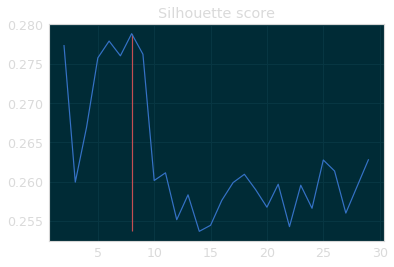

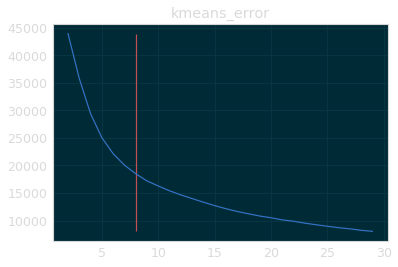

In [25]:
clusters = [{'n_clusters': n} for n in range(2, 30)]
silhouette, error, best_n = validate_clustering(X_s_train, KMeans, clusters, kmeans_error,
                                               'n_clusters')

OK, let's use KMeans with n = 8

Explained variance ratio for the first two components: 0.6782136318932059
Explained variance ratio for the first two components: 0.6797952653449141
Explained variance ratio for the first two components: 0.7960990125179701
Explained variance ratio for the first two components: 0.8441243924210369
Explained variance ratio for the first two components: 0.7287183444128749
Explained variance ratio for the first two components: 0.682340889028062
Explained variance ratio for the first two components: 0.7367031920857852
Explained variance ratio for the first two components: 0.7019972604188371


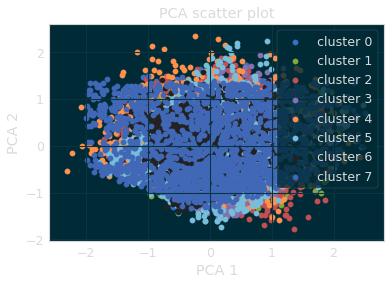

In [26]:
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=2018)
kmeans.fit(X_s_train)
cluster_labels = kmeans.predict(X_s_train)
pca_visualize_clusters(X_s_train, cluster_labels)

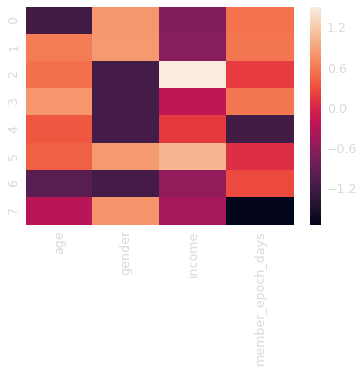

In [27]:
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

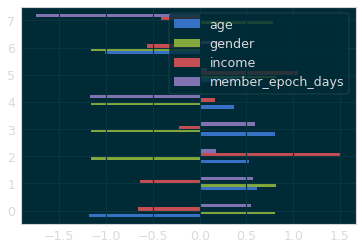

In [28]:
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

In [29]:
X_s_train.gender.unique()

array([ 0.76945298,  2.69936669, -1.16046072])

**Description of the clusters ():**

 - 0) Low income young men. They joined the app more recently than the mean.
 - 1) Low income aged men that recently joined the app.
 - 2) High income women. Sensibly older than the mean.
 - 3) Aged women that joined recently. Slightly lower income than the mean.
 - 4) Early-adopter women. Sligthly higher income and age than the mean.
 - 5) High income men. Sensibly older than the mean.
 - 6) Low income young women. They joined the app more recently than the mean.
 - 7) Early-adopter men. Sligthly lower income and age than the mean.
 
 Reorganized (shows that for every "male" cluster there is a very similar "female" cluster, with minor differences):
 - 4) Early-adopter women. Sligthly higher income and age than the mean.
 - 7) Early-adopter men. Sligthly lower income and age than the mean.
  
  
 - 0) Low income young men. They joined the app more recently than the mean.
 - 6) Low income young women. They joined the app more recently than the mean.
  
  
 - 2) High income women. Sensibly older than the mean.
 - 5) High income men. Sensibly older than the mean.
  
  
 - 1) Low income aged men that recently joined the app. 
 - 3) Aged women that joined recently. Slightly lower income than the mean.


In every cluster it seems like the female customers have a slightly higher income than the male customers. Other genders don't seem to be enough to influence the clusters in a noticeable way.

Text(0.5, 1.0, 'Number of members per cluster')

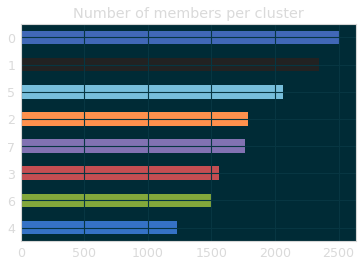

In [30]:
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

In [31]:
for label in range(n_clusters):
    X_clust = X_s_train[cluster_labels == label]
    print('Cluster {}'.format(label))
    print(X_clust.describe())
    print('-'*100)

Cluster 0
               age       gender       income  member_epoch_days
count  2509.000000  2509.000000  2509.000000        2509.000000
mean     -1.181806     0.806374    -0.657129           0.550342
std       0.527424     0.264424     0.601200           0.505595
min      -2.093446     0.769453    -1.638707          -1.210158
25%      -1.633281     0.769453    -1.175796           0.387876
50%      -1.173117     0.769453    -0.666594           0.643084
75%      -0.712953     0.769453    -0.157392           0.919759
max      -0.310310     2.699367     0.861012           1.246521
----------------------------------------------------------------------------------------------------
Cluster 1
               age       gender       income  member_epoch_days
count  2345.000000  2345.000000  2345.000000        2345.000000
mean      0.613158     0.820478    -0.634477           0.568314
std       0.602342     0.309697     0.553269           0.513905
min      -0.252789     0.769453    -1.638707   

### 3.2. Hierarchical (Ward) <a id='ward'/>
[Top](#top)

In [32]:
from scipy.cluster.hierarchy import dendrogram, ward, fcluster
import seaborn as sns

In [33]:
%time linkage_matrix = ward(X_s_train)

CPU times: user 8.73 s, sys: 567 ms, total: 9.3 s
Wall time: 9.32 s


CPU times: user 121 ms, sys: 127 µs, total: 122 ms
Wall time: 121 ms


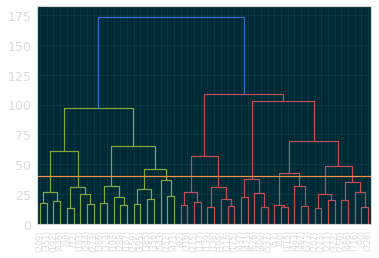

In [34]:
p = 50
%time ddg = dendrogram(linkage_matrix, truncate_mode='lastp', p=p)
plt.hlines(40, 0, 10 * p, colors='y')

With that limit, maybe 12 clusters would be reasonable. Let's check that with the Silhouette score.

CPU times: user 9.95 s, sys: 649 ms, total: 10.6 s
Wall time: 10.6 s


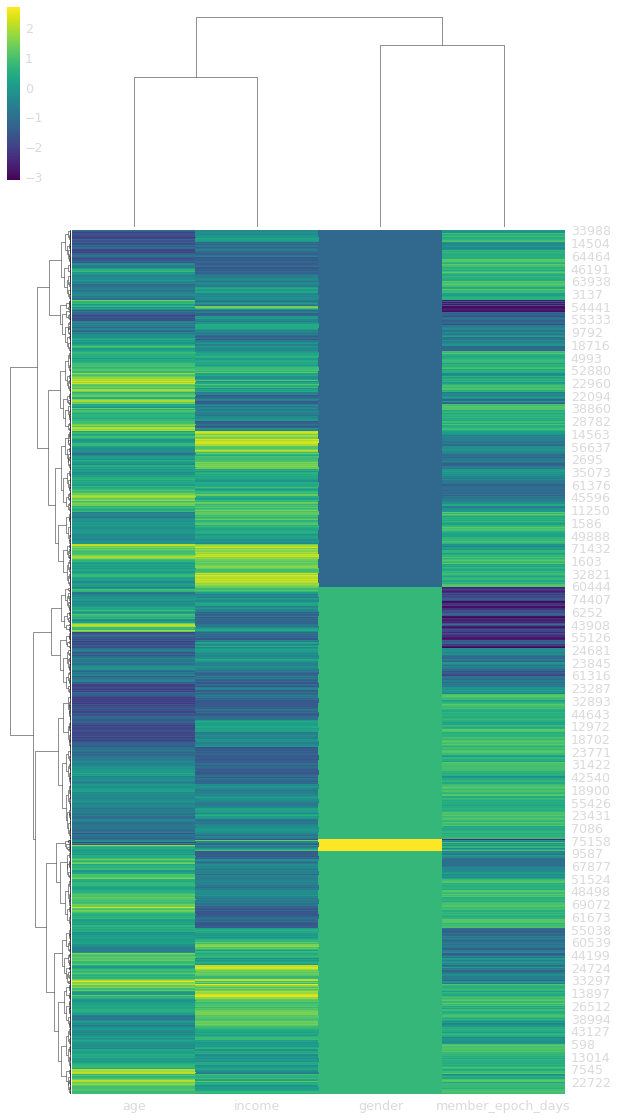

In [35]:
%time sns.clustermap(X_s_train, figsize=(10, 20), method='ward', cmap='viridis')

The most noticeable division seems to be by gender. The other features also seem to cluster the data. For example, "age" seems to divide the "male" cluster pretty well.

In [36]:
from collections import defaultdict

In [37]:
# cut_dists = np.arange(10, 150, 10)
cut_dists = np.exp(np.linspace(0, 5.5, 50))
results = defaultdict(dict)

for i, max_d in enumerate(cut_dists):
    tic = time()
    clusters = fcluster(linkage_matrix, max_d, criterion='distance')
    n_clusters = len(np.unique(clusters))
    
    results['n_clusters'][max_d] = n_clusters
    if n_clusters >= 2:
        results['score'][max_d] = silhouette_score(X_s_train, clusters)
    else:
        results['score'][max_d] = 0
    
    toc = time()
    print('Algorithm {} of {} finished in {} seconds.'.format(
        i + 1, len(cut_dists), (toc - tic)))

Algorithm 1 of 50 finished in 3.882258415222168 seconds.
Algorithm 2 of 50 finished in 3.9695143699645996 seconds.
Algorithm 3 of 50 finished in 3.875810384750366 seconds.
Algorithm 4 of 50 finished in 3.800731658935547 seconds.
Algorithm 5 of 50 finished in 3.8344075679779053 seconds.
Algorithm 6 of 50 finished in 3.619915008544922 seconds.
Algorithm 7 of 50 finished in 3.6443395614624023 seconds.
Algorithm 8 of 50 finished in 3.52506422996521 seconds.
Algorithm 9 of 50 finished in 3.4742517471313477 seconds.
Algorithm 10 of 50 finished in 3.4464051723480225 seconds.
Algorithm 11 of 50 finished in 3.5316412448883057 seconds.
Algorithm 12 of 50 finished in 3.5714447498321533 seconds.
Algorithm 13 of 50 finished in 3.566636562347412 seconds.
Algorithm 14 of 50 finished in 3.586230993270874 seconds.
Algorithm 15 of 50 finished in 3.7202820777893066 seconds.
Algorithm 16 of 50 finished in 3.6098833084106445 seconds.
Algorithm 17 of 50 finished in 3.544070243835449 seconds.
Algorithm 18 of

The best Silhouette score is for 2 clusters (maximum distance = 111.52911905915602), and its value is: 0.2773163761270585


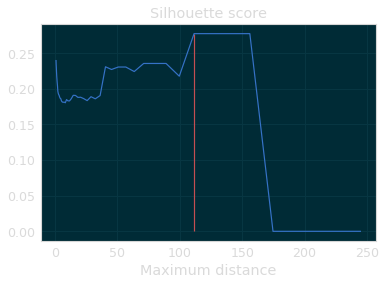

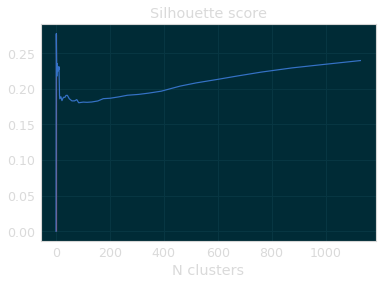

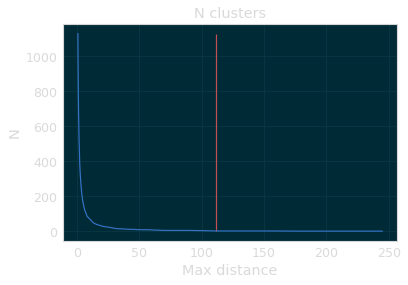

In [38]:
best_d, best_score = max(results['score'].items(), key= lambda x: x[1])
best_n_clust = results['n_clusters'][best_d]
print(
    'The best Silhouette score is for {} clusters (maximum distance '.format(
    best_n_clust) + '= {}), and its value is: {}'.format(best_d, best_score))

# Plot silhouette score vs distance
m_dists = results['score'].keys()
scores = results['score'].values()
plt.plot(m_dists, scores)
plt.title('Silhouette score')
plt.vlines(best_d, min(scores), max(scores), 'r')
plt.xlabel('Maximum distance')

# Plot silhouette score vs n_clusters
plt.figure()
n, score_n = zip(*((results['n_clusters'][d], results['score'][d]) 
                   for d in results['n_clusters'].keys()))
plt.plot(n, score_n)
plt.title('Silhouette score')
plt.vlines(best_n_clust, min(score_n), max(score_n), 'r')
plt.xlabel('N clusters')

# Plot n_clusters vs distance
plt.figure()
m_dists = results['n_clusters'].keys()
n = results['n_clusters'].values()
plt.plot(m_dists, n)
plt.title('N clusters')
plt.xlabel('Max distance')
plt.ylabel('N')
plt.vlines(best_d, 0, max(n), 'r')

Zooming in the area of interest...

Text(0.5, 0, 'N clusters')

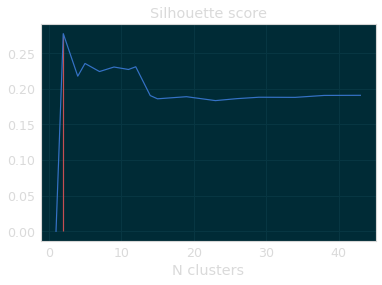

In [39]:
# Plot silhouette score vs n_clusters
n, score_n = zip(*((results['n_clusters'][d], results['score'][d]) 
                   for d in results['n_clusters'].keys()))
n = np.array(n)
score_n = np.array(score_n)
plt.plot(n[n<50], score_n[n<50])
plt.title('Silhouette score')
plt.vlines(best_n_clust, min(score_n[n<20]), max(score_n[n<20]), 'r')
plt.xlabel('N clusters')

It can be seen that about after 12 clusters the silhouette score decreases sensibly. That is in agreement with the initial intuition when looking at the dendrogram. As 12 clusters may be more informative than 2 (probably divided by gender), that may be the chosen number of clusters. Let's visualize both cases.

Let's visualize the results

Explained variance ratio for the first two components: 0.751756547839946
Explained variance ratio for the first two components: 0.7548832827480705


Text(0.5, 1.0, 'Number of members per cluster')

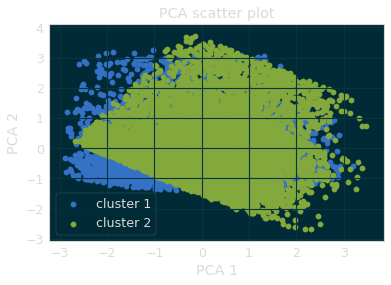

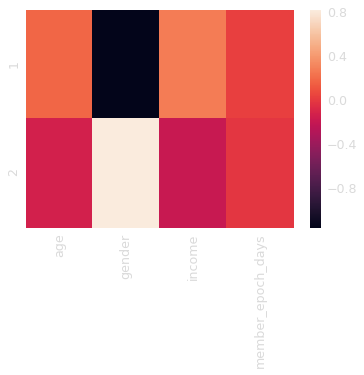

<Figure size 432x288 with 0 Axes>

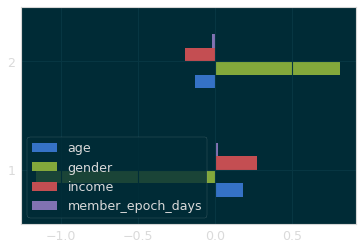

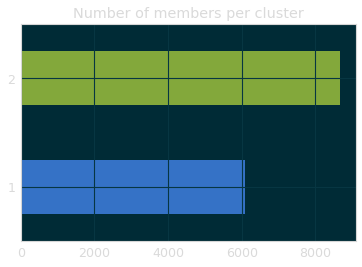

In [40]:
max_d = best_d
cluster_labels = fcluster(linkage_matrix, max_d, criterion='distance')
pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

That is just dividing by gender. Let's try with 12 clusters.

In [41]:
res_df = pd.DataFrame(results)
res_df.index.name = 'distance'
res_df = res_df.reset_index()
res_df.head()

,distance,n_clusters,score
0,1.000000,1129,0.239544
1,1.118787,988,0.233888
2,1.251684,877,0.229317
3,1.400367,762,0.223394
4,1.566713,670,0.217705


In [42]:
res_df.sort_values(by='n_clusters').head(20)

,distance,n_clusters,score
49,244.691932,1,0.000000
46,174.734085,1,0.000000
48,218.711848,1,0.000000
47,195.490191,1,0.000000
45,156.181752,2,0.277316
44,139.599207,2,0.277316
43,124.777308,2,0.277316
42,111.529119,2,0.277316
41,99.687552,4,0.217634
40,89.103260,5,0.235490


In [43]:
dist_12 = res_df[res_df.n_clusters == 12].distance.values[0]
dist_12

40.61273277762122

Explained variance ratio for the first two components: 0.8262869906716721
Explained variance ratio for the first two components: 0.7880787734266306
Explained variance ratio for the first two components: 0.8056964766720367
Explained variance ratio for the first two components: 0.8118939349798578
Explained variance ratio for the first two components: 0.8878030654085182
Explained variance ratio for the first two components: 0.8028703052344561
Explained variance ratio for the first two components: 0.78553977565432
Explained variance ratio for the first two components: 0.8953762720548757
Explained variance ratio for the first two components: 0.750930335637805
Explained variance ratio for the first two components: 0.7940783668945941
Explained variance ratio for the first two components: 0.8740983352959917
Explained variance ratio for the first two components: 0.8705807721661645


Text(0.5, 1.0, 'Number of members per cluster')

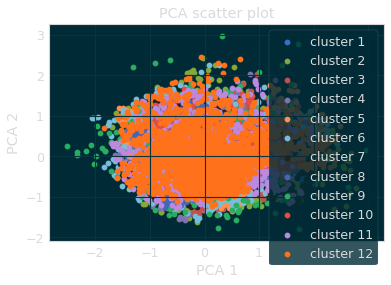

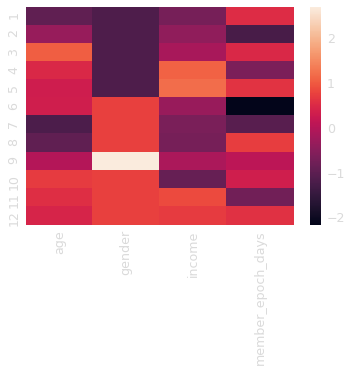

<Figure size 432x288 with 0 Axes>

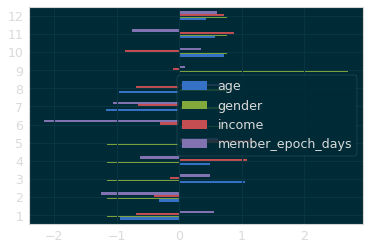

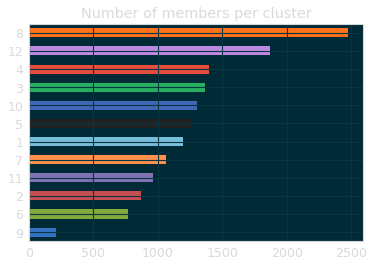

In [44]:
max_d = dist_12
cluster_labels = fcluster(linkage_matrix, max_d, criterion='distance')
pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

What about 9?

In [45]:
dist_9 = res_df[res_df.n_clusters == 9].distance.values[0]
dist_9

50.83430533655655

Explained variance ratio for the first two components: 0.8262869906716724
Explained variance ratio for the first two components: 0.7880787734266308
Explained variance ratio for the first two components: 0.8056964766720365
Explained variance ratio for the first two components: 0.7754377926493254
Explained variance ratio for the first two components: 0.8028703052344559
Explained variance ratio for the first two components: 0.7855397756543201
Explained variance ratio for the first two components: 0.8953762720548755
Explained variance ratio for the first two components: 0.7255508539192913
Explained variance ratio for the first two components: 0.7242155178927967


Text(0.5, 1.0, 'Number of members per cluster')

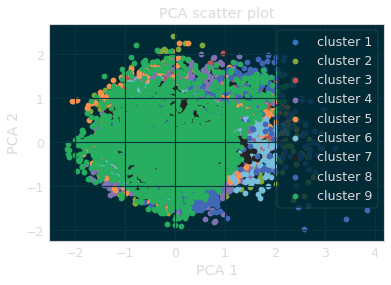

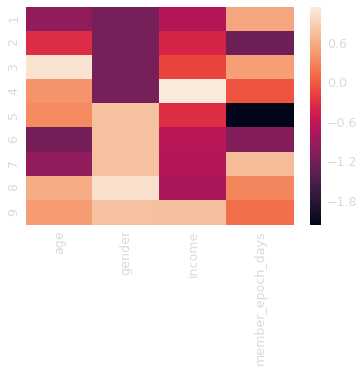

<Figure size 432x288 with 0 Axes>

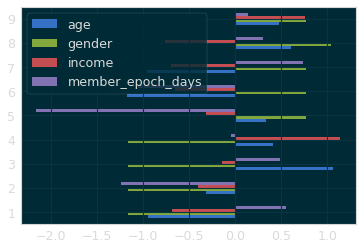

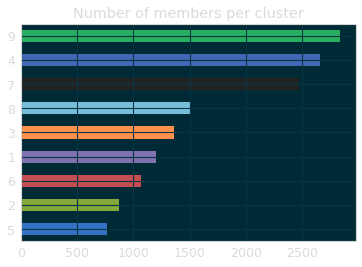

In [46]:
max_d = dist_9
cluster_labels = fcluster(linkage_matrix, max_d, criterion='distance')
pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

The 9 clusters case looks very similar to that found by K-Means, with the difference that Ward seems to have found a new cluster for the people that chose "Other" in gender. We should check if that is the case. I will keep both cases (9 and 12) to generate new features.

### 3.3. GMM <a id='gmm'/>
[Top](#top)

In [47]:
from sklearn.mixture import GaussianMixture

In [48]:
def gmm_aic(X, method, cluster_labels):
    """ 
    Index function that returns the Aikake Information Criterion Index for a 
    Gaussian Mixture Model.
    """
    return method.aic(X)

Algorithm 1 of 28 finished in 3.957545518875122 seconds.
Algorithm 2 of 28 finished in 3.9193594455718994 seconds.
Algorithm 3 of 28 finished in 3.9845805168151855 seconds.
Algorithm 4 of 28 finished in 4.055325269699097 seconds.
Algorithm 5 of 28 finished in 4.360928773880005 seconds.
Algorithm 6 of 28 finished in 5.0879645347595215 seconds.
Algorithm 7 of 28 finished in 4.593909502029419 seconds.
Algorithm 8 of 28 finished in 4.5239198207855225 seconds.
Algorithm 9 of 28 finished in 5.867681264877319 seconds.
Algorithm 10 of 28 finished in 4.870533466339111 seconds.
Algorithm 11 of 28 finished in 4.95098352432251 seconds.
Algorithm 12 of 28 finished in 5.142406225204468 seconds.
Algorithm 13 of 28 finished in 5.0636866092681885 seconds.
Algorithm 14 of 28 finished in 5.069620609283447 seconds.
Algorithm 15 of 28 finished in 5.184472322463989 seconds.
Algorithm 16 of 28 finished in 5.454768180847168 seconds.
Algorithm 17 of 28 finished in 5.731475591659546 seconds.
Algorithm 18 of 28 

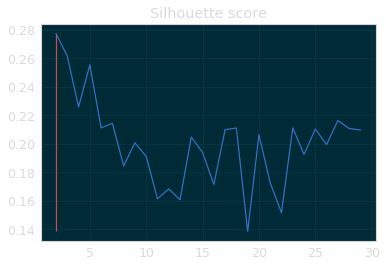

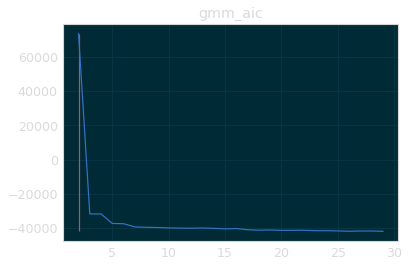

In [49]:
clusters = [{'n_components': n} for n in range(2, 30)]
silhouette, aic, best_n = validate_clustering(X_s_train, GaussianMixture, clusters, gmm_aic,
                                             'n_components')

In [50]:
best_n  # Based on the Silhouette score

{'n_components': 2}

In [51]:
pd.DataFrame([clusters, aic, silhouette], index=['params', 'aic', 'silhouette']).T

,params,aic,silhouette
0,{'n_components': 2},73527.1,0.277316
1,{'n_components': 3},-31770.1,0.261561
2,{'n_components': 4},-31771.2,0.225895
3,{'n_components': 5},-37331.4,0.255437
4,{'n_components': 6},-37477.6,0.211307
5,{'n_components': 7},-39361.6,0.214445
6,{'n_components': 8},-39594.6,0.184553
7,{'n_components': 9},-39697.1,0.200818
8,{'n_components': 10},-39943.6,0.191241
9,{'n_components': 11},-40041.5,0.161502


We should check if the case with 2 clusters is just looking for gender. I would also like to look at the 4-clusters case.

#### 2 clusters

In [52]:
gmm = GaussianMixture(n_components=2)
gmm.fit(X_s_train)
cluster_labels = gmm.predict(X_s_train)

Explained variance ratio for the first two components: 0.7517565478399462
Explained variance ratio for the first two components: 0.7548832827480707


Text(0.5, 1.0, 'Number of members per cluster')

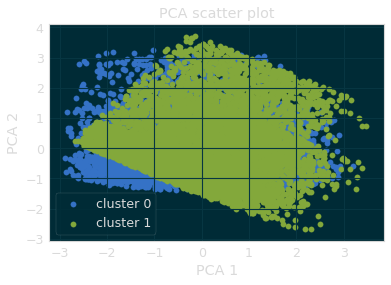

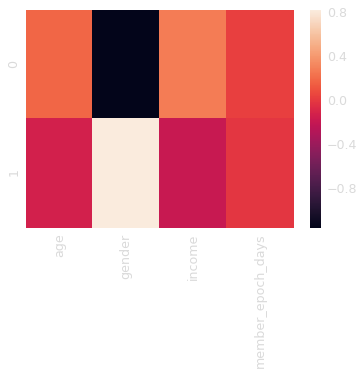

<Figure size 432x288 with 0 Axes>

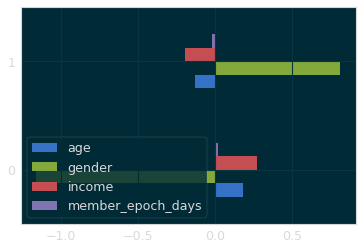

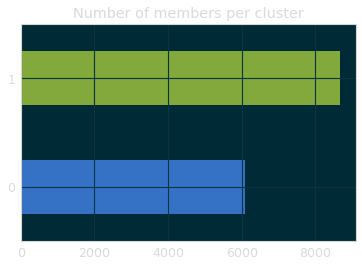

In [53]:
pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

In [54]:
cluster_labels = (unique_train.gender == 0).astype(int)

Explained variance ratio for the first two components: 0.7548832827480698
Explained variance ratio for the first two components: 0.7517565478399467


Text(0.5, 1.0, 'Number of members per cluster')

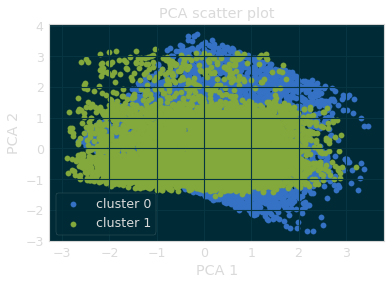

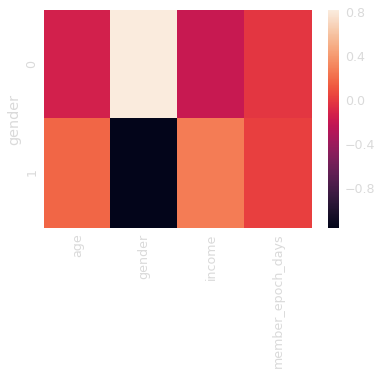

<Figure size 432x288 with 0 Axes>

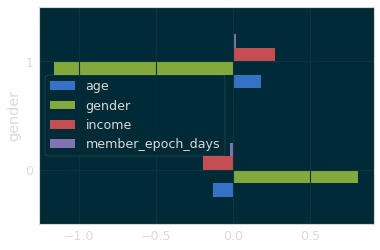

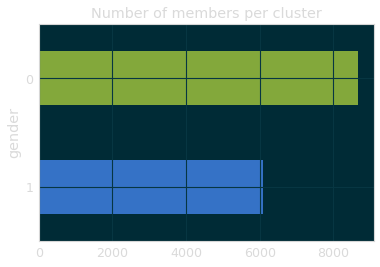

In [55]:
pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

As expected, the 2-clusters case is probably just dividing the dataset by gender. Not an interesting division (it won't give any new information)

#### 4 clusters

In [56]:
gmm = GaussianMixture(n_components=4)
gmm.fit(X_s_train)
cluster_labels = gmm.predict(X_s_train)

Explained variance ratio for the first two components: 0.7517565478399466
Explained variance ratio for the first two components: 0.7657848836268399
Explained variance ratio for the first two components: 0.7779665053326821
Explained variance ratio for the first two components: 0.9219761827188362


Text(0.5, 1.0, 'Number of members per cluster')

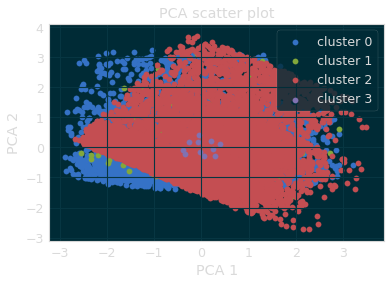

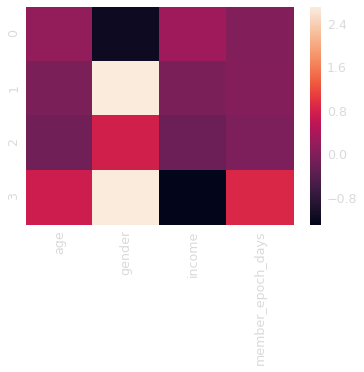

<Figure size 432x288 with 0 Axes>

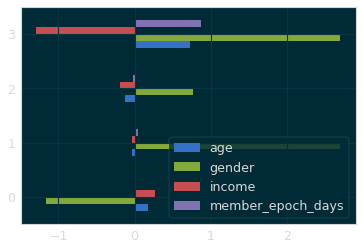

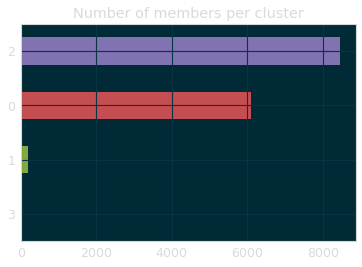

In [57]:
pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

The 4-clusters division is taking into account the people that answered "Other" to the gender question. It's a very small group in the complete dataset. It doesn't look like the Gaussian Mixture Models will give much new information.

### 3.4. DBSCAN <a id='dbscan'/>
[Top](#top)

In [58]:
from sklearn.cluster import DBSCAN

In [59]:
eps = 0.5
min_samples = 5
dbs = DBSCAN(eps=eps, min_samples=min_samples)
dbs.fit(X_s_train)
dbs.labels_

array([0, 1, 2, ..., 0, 0, 2])

In [60]:
len(np.unique(dbs.labels_))

10

In [61]:
def number_of_clusters(X, method, cluster_labels):
    """ Index function that returns the number of clusters for DBSCAN. """
    return len(method.labels_)

In [62]:
n_batch = 20
m_batch = 5
eps_list = np.linspace(0.1, 2.0, n_batch).repeat(m_batch)
min_samples_list = [5, 20, 50, 100, 300] * n_batch
params = [{'eps': e, 'min_samples': ms} for e, ms in zip(eps_list, min_samples_list)]

In [63]:
silhouette = list()
n_clusters = list()
for i, param_set in enumerate(params):
    tic = time()
    method = DBSCAN(**param_set)
    method.fit(X_s_train)
    labels = method.labels_
    try:
        silhouette.append(silhouette_score(X_s_train, labels))
    except ValueError:
        silhouette.append(0)
    n_clusters.append(len(np.unique(labels)))
    toc = time()
    print('Algorithm {} of {} finished in {} seconds. Params: {} Clusters: {}'.format(
        i + 1, len(params), (toc - tic), param_set, len(np.unique(labels))))
    
best_silhouette_params = params[np.argmax(silhouette)]
print('The best Silhouette score is for {}, and its value is: {}'.format(
    best_silhouette_params, max(silhouette)))
print('The number of clusters for {} is: {}'.format(
    best_silhouette_params, n_clusters[np.argmax(silhouette)]))

Algorithm 1 of 100 finished in 4.524086236953735 seconds. Params: {'eps': 0.1, 'min_samples': 5} Clusters: 278
Algorithm 2 of 100 finished in 0.26574158668518066 seconds. Params: {'eps': 0.1, 'min_samples': 20} Clusters: 1
Algorithm 3 of 100 finished in 0.19850873947143555 seconds. Params: {'eps': 0.1, 'min_samples': 50} Clusters: 1
Algorithm 4 of 100 finished in 0.18596363067626953 seconds. Params: {'eps': 0.1, 'min_samples': 100} Clusters: 1
Algorithm 5 of 100 finished in 0.18758416175842285 seconds. Params: {'eps': 0.1, 'min_samples': 300} Clusters: 1
Algorithm 6 of 100 finished in 4.252502679824829 seconds. Params: {'eps': 0.2, 'min_samples': 5} Clusters: 151
Algorithm 7 of 100 finished in 4.387704610824585 seconds. Params: {'eps': 0.2, 'min_samples': 20} Clusters: 18
Algorithm 8 of 100 finished in 0.25980281829833984 seconds. Params: {'eps': 0.2, 'min_samples': 50} Clusters: 1
Algorithm 9 of 100 finished in 0.35053443908691406 seconds. Params: {'eps': 0.2, 'min_samples': 100} Clus

In [64]:
from mpl_toolkits.mplot3d import Axes3D

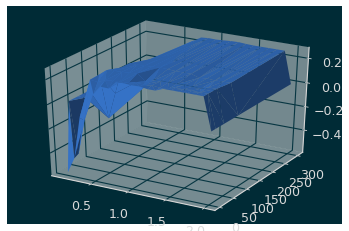

In [65]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(eps_list, min_samples_list, silhouette, linewidth=0.2, antialiased=True)

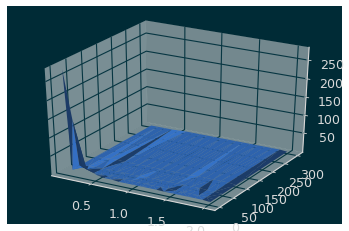

In [66]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_trisurf(eps_list, min_samples_list, n_clusters, linewidth=0.2, antialiased=True)

In [67]:
results = pd.DataFrame([eps_list, min_samples_list, silhouette, n_clusters], 
                      index=['epsilon', 'min_samples', 'silhouette_score', 'n_clusters']).T
results.head()

,epsilon,min_samples,silhouette_score,n_clusters
0,0.1,5.0,-0.57681,278.0
1,0.1,20.0,0.00000,1.0
2,0.1,50.0,0.00000,1.0
3,0.1,100.0,0.00000,1.0
4,0.1,300.0,0.00000,1.0


In [68]:
results.sort_values(by='silhouette_score', ascending=False)

,epsilon,min_samples,silhouette_score,n_clusters
42,0.9,50.0,0.270929,3.0
64,1.3,300.0,0.268715,3.0
48,1.0,100.0,0.268510,3.0
59,1.2,300.0,0.267350,3.0
37,0.8,50.0,0.266011,3.0
53,1.1,100.0,0.265833,3.0
69,1.4,300.0,0.264174,3.0
43,0.9,100.0,0.264084,3.0
54,1.1,300.0,0.263121,3.0
32,0.7,50.0,0.261616,3.0


Let's try with the best values then. 

In [69]:
eps = 0.9
min_samples = 50
dbs = DBSCAN(eps=eps, min_samples=min_samples)
dbs.fit(X_s_train)
cluster_labels = dbs.labels_

Explained variance ratio for the first two components: 0.7709658535290097
Explained variance ratio for the first two components: 0.777857196298626
Explained variance ratio for the first two components: 0.7496109982227278


Text(0.5, 1.0, 'Number of members per cluster')

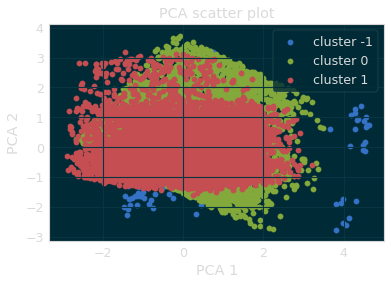

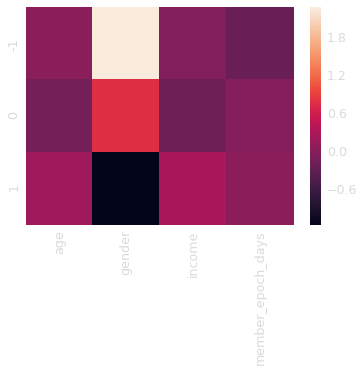

<Figure size 432x288 with 0 Axes>

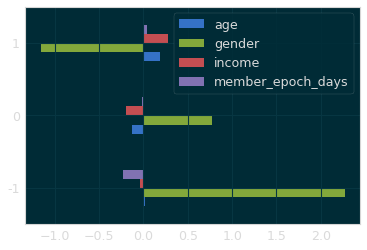

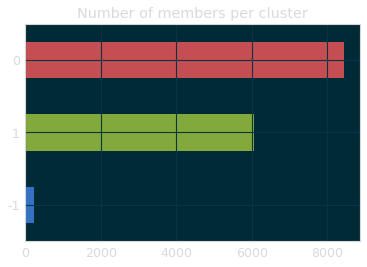

In [70]:
pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

That seems to have divided the dataset by gender (including the option "Other"). Let's try another case, with more clusters.

In [71]:
results.sort_values(by=['n_clusters', 'silhouette_score'], ascending=False).head(15)

,epsilon,min_samples,silhouette_score,n_clusters
0,0.1,5.0,-0.576810,278.0
5,0.2,5.0,-0.444531,151.0
10,0.3,5.0,-0.093571,29.0
15,0.4,5.0,0.016198,19.0
6,0.2,20.0,-0.423905,18.0
20,0.5,5.0,0.120458,10.0
11,0.3,20.0,-0.137059,10.0
25,0.6,5.0,0.189156,6.0
30,0.7,5.0,0.186957,6.0
40,0.9,5.0,0.249391,4.0


#### Case: eps=0.9  min_samples=5

Explained variance ratio for the first two components: 0.9241203453014921
Explained variance ratio for the first two components: 0.7779665053326821
Explained variance ratio for the first two components: 0.7438620996467972
Explained variance ratio for the first two components: 0.7517565478399462


Text(0.5, 1.0, 'Number of members per cluster')

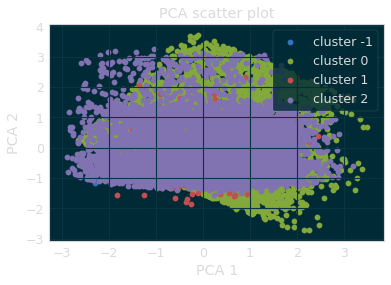

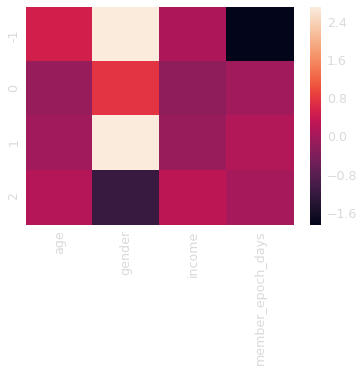

<Figure size 432x288 with 0 Axes>

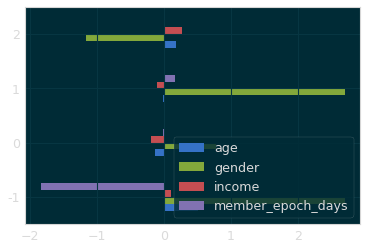

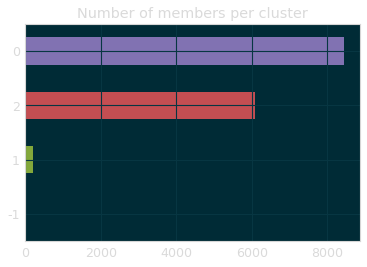

In [72]:
eps = 0.9
min_samples = 5
dbs = DBSCAN(eps=eps, min_samples=min_samples)
dbs.fit(X_s_train)
cluster_labels = dbs.labels_

pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

#### Case: eps=0.3  min_samples=20

Explained variance ratio for the first two components: 0.6337215358909762
Explained variance ratio for the first two components: 0.7790962010609495
Explained variance ratio for the first two components: 0.7931983065505086
Explained variance ratio for the first two components: 0.8310929411692506
Explained variance ratio for the first two components: 0.8807107058136503
Explained variance ratio for the first two components: 0.7926583658507833
Explained variance ratio for the first two components: 0.8341852973002307
Explained variance ratio for the first two components: 0.8027881252083999
Explained variance ratio for the first two components: 0.8758623758746237
Explained variance ratio for the first two components: 0.9000444873902806


Text(0.5, 1.0, 'Number of members per cluster')

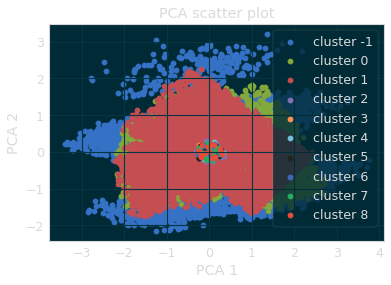

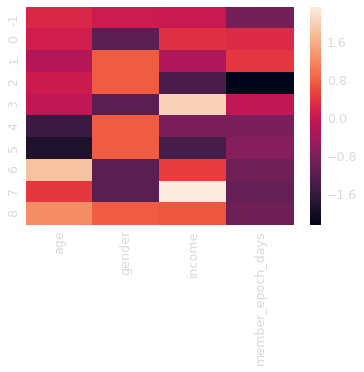

<Figure size 432x288 with 0 Axes>

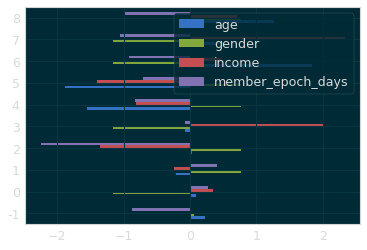

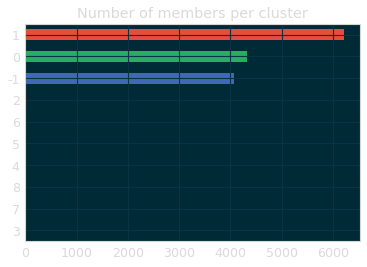

In [73]:
eps = 0.3
min_samples = 20
dbs = DBSCAN(eps=eps, min_samples=min_samples)
dbs.fit(X_s_train)
cluster_labels = dbs.labels_

pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

That's an interesting clustering!

#### Case: eps=0.2  min_samples=20

Explained variance ratio for the first two components: 0.6119520384426762
Explained variance ratio for the first two components: 0.9472907127322787
Explained variance ratio for the first two components: 0.8864734961693621
Explained variance ratio for the first two components: 0.7772043889203908
Explained variance ratio for the first two components: 0.8058796647899945
Explained variance ratio for the first two components: 0.8274914093577561
Explained variance ratio for the first two components: 0.9118101364880007
Explained variance ratio for the first two components: 0.7692847239798049
Explained variance ratio for the first two components: 0.7961287773167911
Explained variance ratio for the first two components: 0.7749008088311715
Explained variance ratio for the first two components: 0.816492789445995
Explained variance ratio for the first two components: 0.8447141841723623
Explained variance ratio for the first two components: 0.8317737564411434
Explained variance ratio for the first 

Text(0.5, 1.0, 'Number of members per cluster')

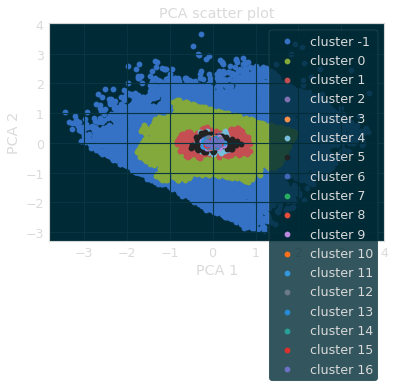

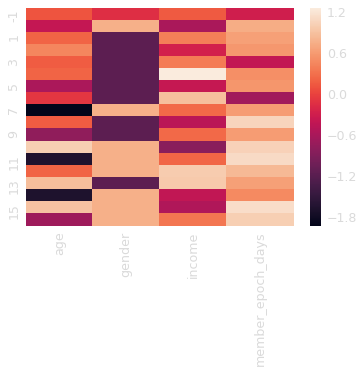

<Figure size 432x288 with 0 Axes>

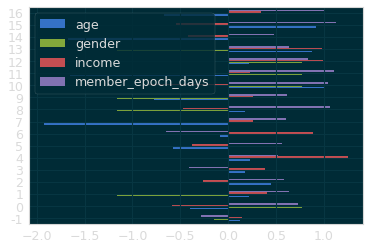

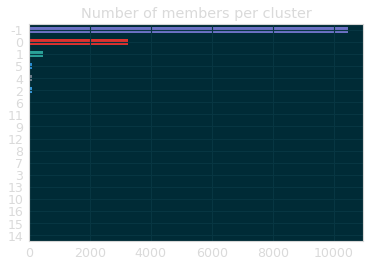

In [74]:
eps = 0.2
min_samples = 20
dbs = DBSCAN(eps=eps, min_samples=min_samples)
dbs.fit(X_s_train)
cluster_labels = dbs.labels_

pca_visualize_clusters(X_s_train, cluster_labels)

plt.figure()
sns.heatmap(X_s_train.groupby(cluster_labels).mean())

plt.figure()
X_s_train.groupby(cluster_labels).mean().plot(kind='barh')

plt.figure()
X_s_train.groupby(cluster_labels).count().age.sort_values().plot(kind='barh')
plt.title('Number of members per cluster')

#### Case: eps=1.5  min_samples=20

I will keep the case with "eps = 0.3,  min_samples = 20" because it seems "reasonable" (20 is a reasonable number for something to be "statistically relevant" and 0.3 is low enough; also 10 clusters is reasonable, and it detected a 3rd relevant cluster that is based on time of membership instead of gender).

## 4. Results Analysis <a id='results'/>
[Top](#top)

First, let's combine all the interesting labels in one dataframe.

In [75]:
results = unique_train.copy()

In [76]:
# K-Means (k = 8)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=2018)
kmeans.fit(X_s_train)
results['kmeans_8'] = kmeans.predict(X_s_train)

In [77]:
# Ward 12 clusters
dist_12 = res_df[res_df.n_clusters == 12].distance.values[0]
results['ward_12'] = fcluster(linkage_matrix, dist_12, criterion='distance')

# Ward 9 clusters
dist_9 = res_df[res_df.n_clusters == 9].distance.values[0]
results['ward_9'] = fcluster(linkage_matrix, dist_9, criterion='distance')

In [78]:
# GMM 4 clusters
gmm = GaussianMixture(n_components=4)
gmm.fit(X_s_train)
results['gmm_4'] = gmm.predict(X_s_train)

In [79]:
# DBSCAN eps=0.3, min_samples=20, 10 clusters
eps = 0.3
min_samples = 20
dbs = DBSCAN(eps=eps, min_samples=min_samples)
dbs.fit(X_s_train)
results['dbscan_10'] = dbs.labels_

In [80]:
results.head()

,age,gender,income,member_epoch_days,kmeans_8,ward_12,ward_9,gmm_4,dbscan_10
0,33.0,1.0,72000.0,17277,0,8,7,1,1
7,40.0,2.0,57000.0,17540,0,9,8,0,-1
12,59.0,0.0,90000.0,16864,4,4,4,2,0
17,24.0,0.0,60000.0,17116,6,1,1,2,-1
21,26.0,0.0,73000.0,17338,6,1,1,2,-1


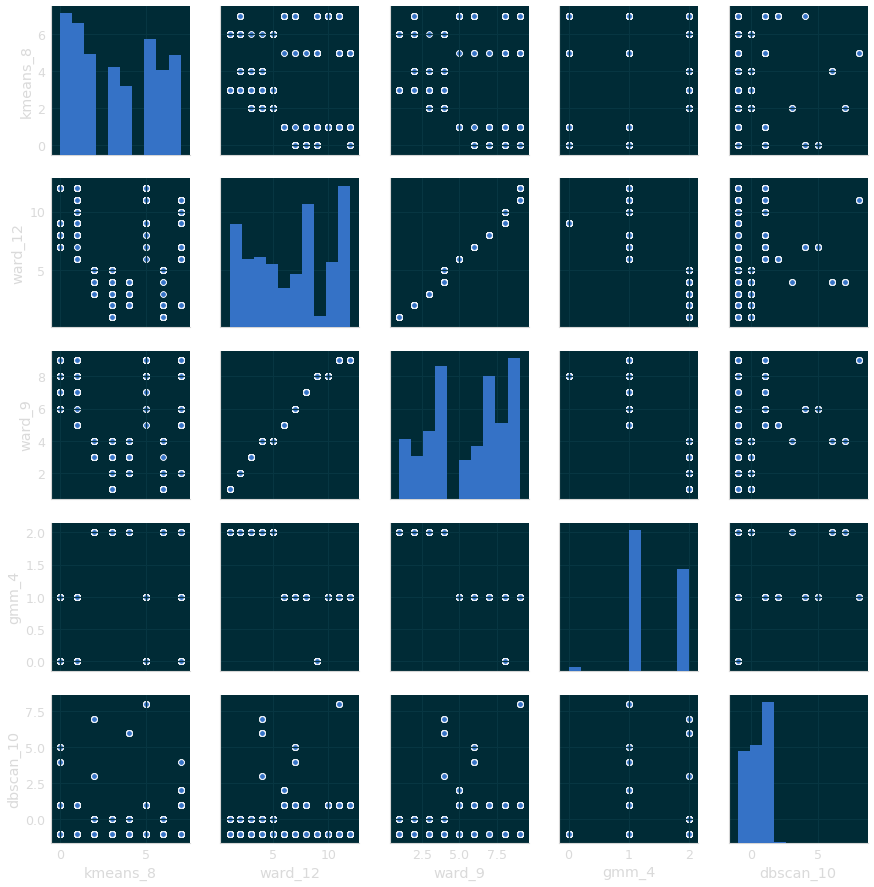

In [81]:
sns.pairplot(results[['kmeans_8', 'ward_12', 'ward_9', 'gmm_4', 'dbscan_10']])

It looks like Ward-12 and Ward-9 are very correlated. Let's drop Ward-9.

It also looks like Ward-12 clustering is a subdivision of gmm-4, and dbscan-10 is almost a subdivision of gmm-4. So, gmm-4 may be redundant (it was previously noted that GMM was not showing interesting results).

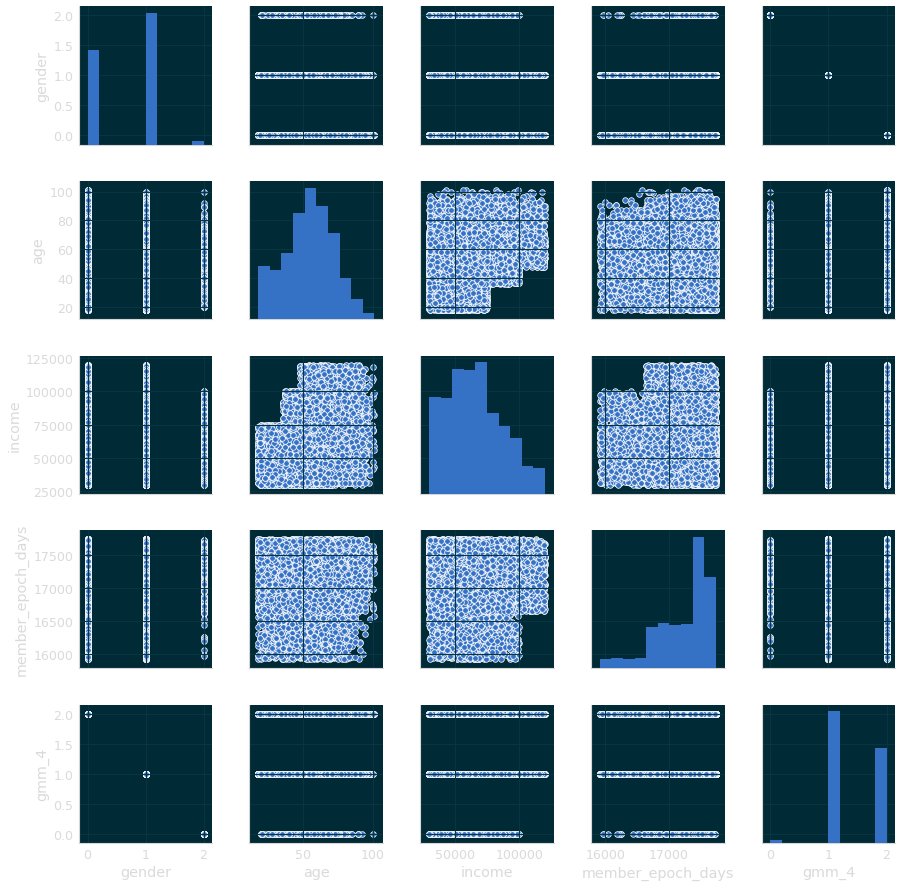

In [82]:
sns.pairplot(results[['gender', 'age', 'income', 'member_epoch_days', 'gmm_4']])

GMM is just encoding gender. Let's drop it too.

In [83]:
results = results.drop(['ward_9', 'gmm_4'], axis=1)

In [84]:
results.head()

,age,gender,income,member_epoch_days,kmeans_8,ward_12,dbscan_10
0,33.0,1.0,72000.0,17277,0,8,1
7,40.0,2.0,57000.0,17540,0,9,-1
12,59.0,0.0,90000.0,16864,4,4,0
17,24.0,0.0,60000.0,17116,6,1,-1
21,26.0,0.0,73000.0,17338,6,1,-1


Let's save the cluster labels in new datasets.

## 5. Saving the data <a id='saving'/>
[Top](#top)

In [85]:
from sklearn.neighbors import KNeighborsClassifier

In [86]:
# Get the data
X_train, X_test, y_train, y_test, encoder = sd.get_success_data(drop_time=False,
                                                                anon=False)

# Encode and filter relevant features
customer_feats = ['age', 'gender', 'income', 'missing_demographics', 
                  'member_epoch_days']
offer_feats = ['difficulty', 'duration', 'offer_type', 'reward_t', 
               'channel_web', 'channel_social', 'channel_mobile', 
               'channel_email']

X_train_t = encoder.fit_transform(X_train)
X_train_t = X_train_t[customer_feats]
X_test_t = encoder.transform(X_test)
X_test_t = X_test_t[customer_feats]

# Drop duplicates and missing data
X_train_t = X_train_t.dropna().drop_duplicates()
X_test_t = X_test_t.dropna().drop_duplicates()

# Keep a copy with the original demographics
X_train_o = pp.gender_decode(X_train_t.copy())
X_test_o = pp.gender_decode(X_test_t.copy())

# Drop the irrelevant column
X_train_t = X_train_t.drop('missing_demographics', axis=1)
X_test_t = X_test_t.drop('missing_demographics', axis=1)

# Normalize
scaler = StandardScaler()
scaler.fit(X_train_t)

X_train_t = pd.DataFrame(scaler.transform(X_train_t),
                         index=X_train_t.index,
                         columns=X_train_t.columns)
X_test_t = pd.DataFrame(scaler.transform(X_test_t),
                         index=X_test_t.index,
                         columns=X_test_t.columns)

# Add the clustering labels
# K-Means (k = 8)
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters, random_state=2018)
kmeans.fit(X_train_t)
X_train_o['kmeans_8'] = kmeans.predict(X_train_t)
X_test_o['kmeans_8'] = kmeans.predict(X_test_t)

# Ward 12 clusters
dist_12 = res_df[res_df.n_clusters == 12].distance.values[0]
X_train_o['ward_12'] = fcluster(linkage_matrix, dist_12, criterion='distance')
# Use KNN to determine the test clusters
knn_ward = KNeighborsClassifier(n_neighbors=5)
knn_ward.fit(X_train_t, X_train_o['ward_12'])
X_test_o['ward_12'] = knn_ward.predict(X_test_t)

# DBSCAN eps=0.3, min_samples=20, 10 clusters
eps = 0.3
min_samples = 20
dbs = DBSCAN(eps=eps, min_samples=min_samples)
dbs.fit(X_train_t)
X_train_o['dbscan_10'] = dbs.labels_
# Use KNN to determine the test clusters
knn_dbscan = KNeighborsClassifier(n_neighbors=5)
knn_dbscan.fit(X_train_t, X_train_o['dbscan_10'])
X_test_o['dbscan_10'] = knn_dbscan.predict(X_test_t)



# Merge with the original datsets
X_train_r = X_train.merge(X_train_o, on=customer_feats, how='left')
X_test_r = X_test.merge(X_test_o, on=customer_feats, how='left')

/home/miguel/anaconda3/envs/sbucks/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/miguel/anaconda3/envs/sbucks/lib/python3.7/site-packages/ipykernel_launcher.py:33: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/home/miguel/anaconda3/envs/sbucks/lib/python3.7/site-packages/ipykernel_launcher.py:36: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


In [87]:
X_train_r.head()

,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,offer_type,reward_t,channel_email,channel_social,channel_mobile,channel_web,expected_finish,kmeans_8,ward_12,dbscan_10
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,informational,0.0,1.0,1.0,1.0,0.0,240.0,0.0,8.0,1.0
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,informational,0.0,1.0,0.0,1.0,1.0,432.0,0.0,8.0,1.0
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,...,bogo,5.0,1.0,1.0,1.0,1.0,528.0,0.0,8.0,1.0
3,00116118485d4dfda04fdbaba9a87b5c,168,f19421c1d4aa40978ebb69ca19b0e20d,NaN,2018-04-25,None,NaN,1,17646,5.0,...,bogo,5.0,1.0,1.0,1.0,1.0,288.0,NaN,NaN,NaN
4,0011e0d4e6b944f998e987f904e8c1e5,0,3f207df678b143eea3cee63160fa8bed,40.0,2018-01-09,O,57000.0,0,17540,0.0,...,informational,0.0,1.0,0.0,1.0,1.0,96.0,0.0,9.0,-1.0


In [88]:
X_test_r.head()

,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,offer_type,reward_t,channel_email,channel_social,channel_mobile,channel_web,expected_finish,kmeans_8,ward_12,dbscan_10
0,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,discount,2.0,1.0,1.0,1.0,1.0,744.0,0.0,8.0,1.0
1,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,discount,2.0,1.0,0.0,1.0,1.0,744.0,0.0,8.0,1.0
2,00116118485d4dfda04fdbaba9a87b5c,576,f19421c1d4aa40978ebb69ca19b0e20d,NaN,2018-04-25,None,NaN,1,17646,5.0,...,bogo,5.0,1.0,1.0,1.0,1.0,696.0,NaN,NaN,NaN
3,0011e0d4e6b944f998e987f904e8c1e5,504,9b98b8c7a33c4b65b9aebfe6a799e6d9,40.0,2018-01-09,O,57000.0,0,17540,5.0,...,bogo,5.0,1.0,0.0,1.0,1.0,672.0,0.0,9.0,-1.0
4,0020c2b971eb4e9188eac86d93036a77,504,5a8bc65990b245e5a138643cd4eb9837,59.0,2016-03-04,F,90000.0,0,16864,0.0,...,informational,0.0,1.0,1.0,1.0,0.0,576.0,4.0,4.0,0.0


In [89]:
X_train_r.to_pickle(os.path.join(DATA_PROCESSED, 'X_train_cluster1.pkl'))
X_test_r.to_pickle(os.path.join(DATA_PROCESSED, 'X_test_cluster1.pkl'))
y_train.to_pickle(os.path.join(DATA_PROCESSED, 'y_train_cluster1.pkl'))
y_test.to_pickle(os.path.join(DATA_PROCESSED, 'y_test_cluster1.pkl'))

Let's join this with the complete static dataset

In [90]:
X_train_r.time.unique()

array([168, 336, 408,   0])

In [91]:
X_test_r.time.unique()

array([504, 576])

In [92]:
static_cluster1 = pd.concat([X_train_r.sort_values(by='time'), X_test_r.sort_values(by='time')])
static_cluster1.head()

,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,offer_type,reward_t,channel_email,channel_social,channel_mobile,channel_web,expected_finish,kmeans_8,ward_12,dbscan_10
25403,80242cc3d985484fbeeeb7d3cf828b71,0,2906b810c7d4411798c6938adc9daaa5,63.0,2016-10-25,F,94000.0,0,17099,10.0,...,discount,2.0,1.0,0.0,1.0,1.0,168.0,2.0,4.0,0.0
9445,30b6bdaf06b84019b0ef65c69fa5b478,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,54.0,2016-11-22,F,70000.0,0,17127,5.0,...,bogo,5.0,1.0,0.0,1.0,1.0,168.0,4.0,4.0,0.0
36675,b78e48b42f1b416e84504333ea442401,0,3f207df678b143eea3cee63160fa8bed,41.0,2018-06-23,F,57000.0,0,17705,0.0,...,informational,0.0,1.0,0.0,1.0,1.0,96.0,6.0,1.0,0.0
16711,54b33c0fc40448338ef24516672bd472,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,32.0,2014-09-04,M,43000.0,0,16317,20.0,...,discount,5.0,1.0,0.0,0.0,1.0,240.0,7.0,7.0,-1.0
36672,b78ca0a03dc34894be476f581c610e84,0,5a8bc65990b245e5a138643cd4eb9837,37.0,2016-02-17,F,40000.0,0,16848,0.0,...,informational,0.0,1.0,1.0,1.0,0.0,72.0,6.0,2.0,-1.0


In [93]:
static_cluster1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 25403 to 25468
Data columns (total 21 columns):
person                  76277 non-null object
time                    76277 non-null int64
offer_id                76277 non-null object
age                     66501 non-null float64
became_member_on        76277 non-null datetime64[ns]
gender                  66501 non-null object
income                  66501 non-null float64
missing_demographics    76277 non-null int64
member_epoch_days       76277 non-null int64
difficulty              76277 non-null float64
duration                76277 non-null float64
offer_type              76277 non-null object
reward_t                76277 non-null float64
channel_email           76277 non-null float64
channel_social          76277 non-null float64
channel_mobile          76277 non-null float64
channel_web             76277 non-null float64
expected_finish         76277 non-null float64
kmeans_8                66501 non-null float

In [94]:
static = pd.read_pickle(os.path.join(DATA_INTERIM, 'static_data.pkl'))

In [95]:
id_feats = ['person', 'time', 'offer_id']
cluster_feats = ['kmeans_8', 'ward_12', 'dbscan_10']
cluster_info = static_cluster1[id_feats + cluster_feats]
static_cluster1_dataset = static.merge(cluster_info, on=id_feats)
static_cluster1_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76277 entries, 0 to 76276
Data columns (total 31 columns):
person                   76277 non-null object
time                     76277 non-null int64
offer_id                 76277 non-null object
age                      66501 non-null float64
became_member_on         76277 non-null datetime64[ns]
gender                   66501 non-null object
income                   66501 non-null float64
missing_demographics     76277 non-null int64
member_epoch_days        76277 non-null int64
difficulty               76277 non-null float64
duration                 76277 non-null float64
offer_type               76277 non-null object
reward_t                 76277 non-null float64
channel_mobile           76277 non-null float64
channel_email            76277 non-null float64
channel_web              76277 non-null float64
channel_social           76277 non-null float64
completed                76277 non-null int64
expected_finish          76277 n

In [96]:
static_cluster1_dataset.to_pickle(os.path.join(DATA_PROCESSED, 'static_cluster1.pkl'))